# Heart Disease Prediction

This notebook aims to predict heart disease using various machine learning techniques. The dataset includes several medical attributes that contribute to heart disease outcomes. We will perform data preprocessing, explore the creation of interaction terms, encode categorical variables, and apply machine learning models to predict the presence of heart disease.

# Made by: German Novykov, Pidnebesnyi Alex, Mark Vaikul

### Import Libraries

In [ ]:
!pip install sweetviz
!pip install --upgrade setuptools

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sweetviz as sv

C:\Users\Windows\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading and Preliminary Exploration

We start by loading the training and test datasets and conduct a brief exploration to understand the structure and type of data we are dealing with.

In [3]:
# Load the data
train_data = pd.read_csv('train_heart.csv', sep=',')
test_data = pd.read_csv('test_heart.csv', sep=',')

# Display the first few rows of the training data
train_data.head()

,id,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,563,55,M,ASY,135,204,1,ST,126,Y,1.1,Flat,1
1,884,67,M,ASY,160,286,0,LVH,108,Y,1.5,Flat,1
2,352,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
3,694,56,M,ATA,120,236,0,Normal,178,N,0.8,Up,0
4,491,75,M,ASY,170,203,1,ST,108,N,0.0,Flat,1


In [3]:
report = sv.analyze(train_data)

report.show_html('heart_analysis.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report heart_analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Data Preprocessing

In this section, we address missing values, create interaction terms, encode categorical variables, and scale the features to prepare our data for modeling.

First, we address potential outliers and missing values in the dataset. Specifically, we focus on two important variables: `Cholesterol` and `RestingBP` (Resting Blood Pressure). Zero values in these variables are not plausible and likely indicate missing or incorrectly recorded data. We replace these zero values with the median value of the respective variable, which is a robust measure of central tendency that is less sensitive to outliers.

In [4]:
# Filter values for Cholesterol and RestingBP
chol_median = train_data.loc[train_data['Cholesterol'] != 0, 'Cholesterol'].median()
train_data['Cholesterol'].replace(0, chol_median, inplace=True)

resting_median = train_data.loc[train_data['RestingBP'] != 0, 'RestingBP'].median()
train_data['RestingBP'].replace(0, resting_median, inplace=True)

#### Create Interaction Term

Interaction terms can capture the effect of two or more variables acting together on the target variable. Here, we create an interaction term between `Age` and `Cholesterol`, hypothesizing that the combination of these variables might have a different effect on heart disease risk compared to considering them individually.

In [5]:
train_data['Age_Chol_Interact'] = train_data['Age'] * train_data['Cholesterol']

#### Encode Categorical Variables

Many machine learning models cannot handle categorical variables unless they are converted into numerical values. We use ordinal encoding to transform these variables into a numerical format while preserving the order of categories when applicable.

In [6]:
# ENCODE CATEGORICAL VARIABLES

categorical_columns = train_data.select_dtypes(include=['object']).columns

ordinal_encoder  = ce.OrdinalEncoder(cols=categorical_columns)
features_encoded  = ordinal_encoder.fit_transform(train_data.drop(['id', 'HeartDisease'], axis=1))

#### Add Polynomial Features

Polynomial features are generated by raising existing features to an exponent. This technique helps to capture interactions between the original features by adding squared or higher order terms of the features. It can uncover complex relationships between features and the target variable.

In [7]:
# Instantiate and apply PolynomialFeatures
poly_features_transformer = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly_features_transformer.fit_transform(features_encoded)
polynomial_feature_names = poly_features_transformer.get_feature_names_out(input_features=ordinal_encoder.get_feature_names_out())

#### Scale Features
Feature scaling is essential to normalize the range of independent variables or features of data. In the absence of scaling, the model might get biased toward high values. We use StandardScaler for this purpose, which standardizes features by removing the mean and scaling to unit variance.

In [8]:
standard_scaler = StandardScaler()
features_scaled = standard_scaler.fit_transform(features_poly)

The final step in data preprocessing is splitting the dataset into training and test sets. This allows us to train our model on one subset of the data and then test it on a separate subset to evaluate its performance.

In [9]:
# Define the target variable
target_variable = train_data['HeartDisease']

# Split the data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features_scaled, target_variable, test_size=0.3, random_state=42)

With the data preprocessing completed, we're now ready to move on to the next steps: model training and evaluation

### Feature Engineering and Model Preparation

In this step, we focus on optimizing the model's performance through hyperparameter tuning. Hyperparameters are the settings that can be adjusted to control the model's learning process. Tuning these parameters helps in finding the best version of the model that can predict more accurately.

For our Decision Tree classifier, we will explore a range of hyperparameters to find the best combination that yields the highest accuracy. This process is facilitated by `GridSearchCV`, a tool that performs exhaustive search over specified parameter values for an estimator.

#### Hyperparameter Tuning for Decision Tree Classifier

The parameters we are tuning include:
- `max_depth`: The maximum depth of the tree.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `ccp_alpha`: Complexity parameter used for Minimal Cost-Complexity Pruning.
- `splitter`: The strategy used to choose the split at each node.
- `class_weight`: Weights associated with classes.

The goal is to find the optimal settings that lead to the best model performance.

In [10]:
# Decision Tree Hyperparameter Grid
dt_param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

# Decision Tree Grid Search Setup
dt_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Conduct Grid Search
dt_grid_search.fit(features_train, target_train)

# Optimal Decision Tree Estimator
optimal_dt = dt_grid_search.best_estimator_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


With the best hyperparameters identified, we can now proceed to use this optimally tuned Decision Tree as the base estimator for our AdaBoost classifier. This ensures that our ensemble model starts with a strong foundation.

### Model Training with AdaBoost and Stacking Ensemble

#### Enhancing Decision Tree Performance with AdaBoost

Following the hyperparameter tuning of our Decision Tree model, we elevate the model training process by integrating AdaBoost, an ensemble technique. AdaBoost enhances the model's predictive power by sequentially adjusting the weights of incorrectly classified instances, thereby sharpening its focus on challenging cases.

### Implementing AdaBoost and Stacking Ensemble

We employ AdaBoost with the optimally tuned Decision Tree as the base estimator. Additionally, we explore a stacking ensemble approach, combining the strengths of AdaBoost, RandomForest, and Logistic Regression to build a robust classifier. This ensemble technique leverages multiple learning algorithms to achieve better predictive performance than any of the constituent models could achieve alone.

In [11]:
# AdaBoost with Tuned Decision Tree
ada_boost_classifier = AdaBoostClassifier(estimator=optimal_dt, n_estimators=1000, random_state=42)

# Additional Base Models for Stacking
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
logistic_regression_classifier = LogisticRegression()

# Base Model Setup for Stacking
base_classifiers = [
    ('ada_boost', ada_boost_classifier),
    ('random_forest', random_forest_classifier),
    ('logistic_regression', logistic_regression_classifier)
]

# Meta-Model for Stacking
stacking_meta_classifier = LogisticRegression()

# Stacking Ensemble Setup
stacking_ensemble_classifier = VotingClassifier(estimators=base_classifiers, voting="hard", n_jobs=-1)

# Train Stacking Ensemble
stacking_ensemble_classifier.fit(features_train, target_train)

# Ensemble Prediction on Test Data
predictions_stacking = stacking_ensemble_classifier.predict(features_test)

# Predict 

# Stacking Ensemble Accuracy
accuracy_stacking_ensemble = accuracy_score(target_test, predictions_stacking)
print(f'Stacking Ensemble Model Accuracy: {accuracy_stacking_ensemble}')

Stacking Ensemble Model Accuracy: 0.8549222797927462


### Evaluating the Model

The final step in model training is to evaluate the performance of our classifier. We do this by calculating the confusion matrix and classification report, which provide insights into the accuracy, precision, recall, and F1-score of the model.

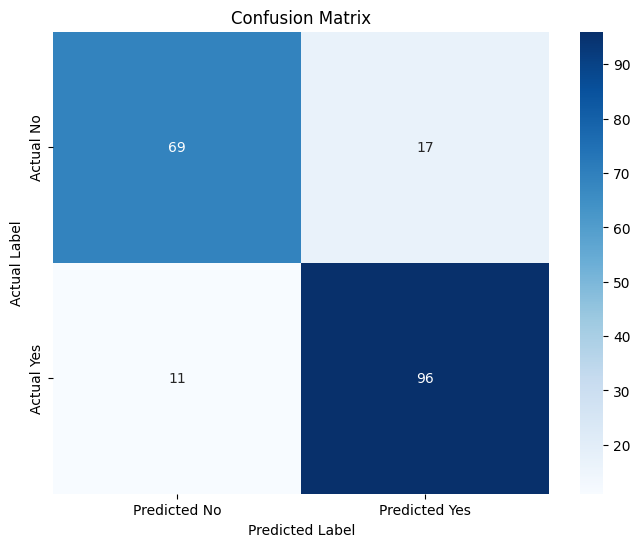


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83        86
           1       0.85      0.90      0.87       107

    accuracy                           0.85       193
   macro avg       0.86      0.85      0.85       193
weighted avg       0.86      0.85      0.85       193



In [12]:
# Confusion Matrix and Classification Report
confusion_mat = confusion_matrix(target_test, predictions_stacking)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
plt.show()

# Generating Classification Report
classification_rep = classification_report(target_test, predictions_stacking)
print("\nClassification Report:\n", classification_rep)

Through these evaluation metrics, we can assess the model's ability to classify instances accurately and understand its strengths and weaknesses in predicting heart disease. This critical analysis guides us in making any necessary adjustments to improve model performance further.

### Individual Model Performance Analysis

In order to thoroughly understand the strengths and limitations of our ensemble approach, it's crucial to evaluate the performance of each constituent model independently.

In [13]:
# AdaBoost Decision Tree Accuracy
ada_boost_classifier.fit(features_train, target_train)
ada_boost_predictions = ada_boost_classifier.predict(features_test)
accuracy_ada_boost = accuracy_score(target_test, ada_boost_predictions)
print(f'AdaBoost Decision Tree Accuracy: {accuracy_ada_boost:.4f}')

# Random Forest Accuracy
random_forest_classifier.fit(features_train, target_train)
random_forest_predictions = random_forest_classifier.predict(features_test)
accuracy_rf = accuracy_score(target_test, random_forest_predictions)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')

# Logistic Regression Accuracy
logistic_regression_classifier.fit(features_train, target_train)
logistic_regression_predictions = logistic_regression_classifier.predict(features_test)
accuracy_lr = accuracy_score(target_test, logistic_regression_predictions)
print(f'Logistic Regression Accuracy: {accuracy_lr:.4f}')

C:\Users\Windows\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Decision Tree Accuracy: 0.8394
Random Forest Accuracy: 0.8653
Logistic Regression Accuracy: 0.8549


### Precision-Recall Curve

The Precision-Recall Curve is a powerful tool for models where the balance between precision and recall is crucial, especially in datasets with significant class imbalance. It shows the trade-off between precision (the proportion of true positive results in all positive predictions) and recall (the proportion of true positive results in all actual positives). 

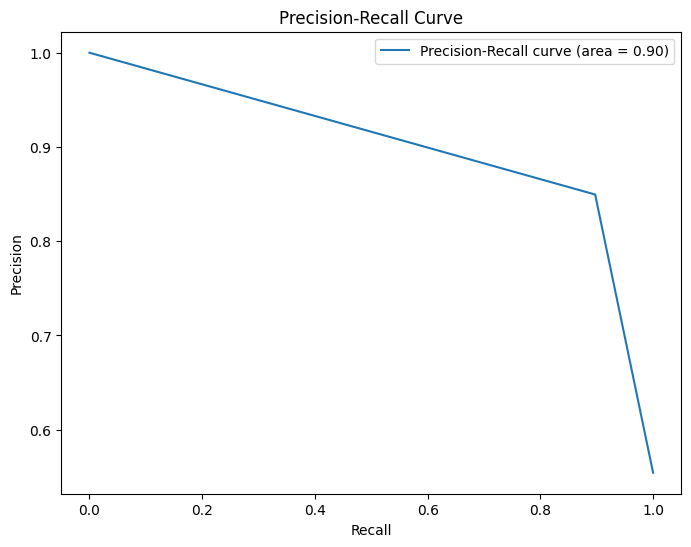

In [14]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_true, y_scores):
    """
    Plot Precision-Recall curve for the model.
    
    Parameters:
    - y_true: Actual target values.
    - y_scores: Target scores, can either be probability estimates of the positive class.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_score = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()


# Precision-Recall Curve for Ensemble Model
plot_precision_recall_curve(target_test, predictions_stacking)

#### Feature Importance Plot 

This function takes a trained model and a list of feature names as inputs and plots the importance of the top N features in the model. Feature importance is determined by how much each feature contributes to the model's decision-making process. 

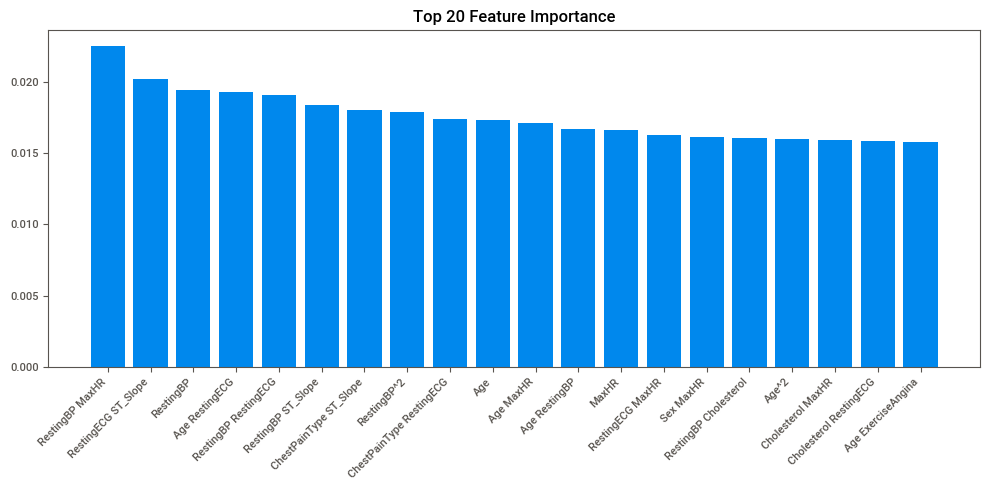

In [26]:

def plot_feature_importance(model, feature_names, top_n_features=20):
    """
    Plot the importance of features in the model.
    
    Parameters:
    - model: The trained model.
    - feature_names: List of names corresponding to the features used by the model.
    """
    # Extract feature importance from the model
    importances = model.feature_importances_
    
    # Sort feature importances in descending order and select the top N
    indices = np.argsort(importances)[::-1][:top_n_features]
    
    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]
    
    # Create plot
    plt.figure(figsize=(10, 5))
    plt.title("Top {} Feature Importance".format(top_n_features))
    plt.bar(range(top_n_features), sorted_importances, align='center')
    
    # Add feature names as x-axis labels
    plt.xticks(range(top_n_features), names, rotation=45, ha='right')
    
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

plot_feature_importance(ada_boost_classifier, polynomial_feature_names)

### Testing on New Data

Preparing and Predicting with the Test Data

Having trained and evaluated our model on a training dataset, the next critical step is to test its performance on new, unseen data. This step is essential for understanding how well our model generalizes to data it has not encountered before. We follow the same data preprocessing steps for the new dataset as we did for the training dataset. Finally, we use our trained model to make predictions on this new data and prepare a submission file with these predictions.

#### Preparing the Test Data

The new data must be preprocessed to match the format expected by the model. This involves filtering out missing or implausible values, creating interaction terms, encoding categorical variables, adding polynomial features, and scaling the features, just as we did with the training data.


In [15]:
# Import the test dataset
test_data = pd.read_csv('test_heart.csv', sep=',')

# Preprocessing: Filter out missing or implausible values for Cholesterol and RestingBP
chol_median = test_data.loc[test_data['Cholesterol'] != 0, 'Cholesterol'].median()
test_data['Cholesterol'].replace(0, chol_median, inplace=True)

restingBP_median = test_data.loc[test_data['RestingBP'] != 0, 'RestingBP'].median()
test_data['RestingBP'].replace(0, restingBP_median, inplace=True)

# Create interaction term
test_data['Age_Chol_Interact'] = test_data['Age'] * test_data['Cholesterol']

# Preparing the test data
features_test_new = test_data.drop(['id'], axis=1)

# Encoding and transforming the test data
features_test_new_encoded = ordinal_encoder.transform(features_test_new)
features_test_new_poly = poly_features_transformer.transform(features_test_new_encoded)
features_test_new_scaled = standard_scaler.transform(features_test_new_poly)

#### Making Predictions and Adjusting Threshold
With the test data prepared, we predict the likelihood of heart disease. We then apply a chosen threshold to these predictions to classify each instance as either having heart disease or not. This threshold is adjustable based on the specific requirements of the task or the desired balance between sensitivity and specificity.

#### Preparing the Submission File
Finally, we prepare a submission file that includes the predictions for the new data. This file typically contains an ID for each instance and the corresponding prediction. This step is especially relevant in competition or operational settings where predictions need to be shared or deployed.

In [17]:
# Predict with the stacked ensemble model
predictions_test_new_stacking = stacking_ensemble_classifier.predict(features_test_new_scaled)

# Create a submission DataFrame
submission_stacking = pd.DataFrame({
    'id': test_data['id'],
    'HeartDisease': predictions_test_new_stacking
})

# Save to CSV file
submission_stacking.to_csv('predictions_stacking_submission.csv', index=False)

This step concludes our process of developing a model to predict heart disease. By carefully preparing the test data, making informed predictions, and generating a submission file, we have applied our model to new data, showcasing its potential for real-world applications.

### Use of GenAI

We used ChatGPT to clean up our code and documentation, making them more efficient. Although it sometimes recommended outdated solutions, it was great for organizing documentation and naming variables. ChatGPT also helped us analyze our data better with visual methods.

In short, ChatGPT was very useful for documentation and data analysis, but it's important to double-check its technical suggestions.